Total samples in dataset: 50000


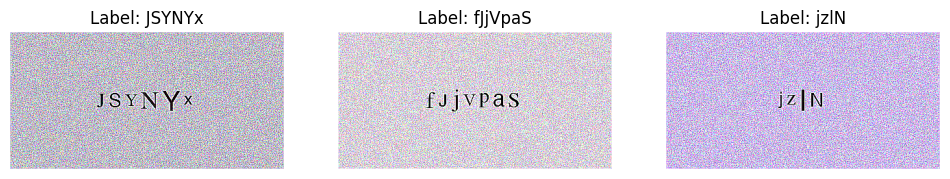


Epoch 1/30


Train Loss: 4.3481 | Val Loss: 3.9759 | Val Word Acc: 0.0000

Epoch 2/30


Train Loss: 4.3025 | Val Loss: 4.3758 | Val Word Acc: 0.0000

Epoch 3/30


Train Loss: 4.3109 | Val Loss: 4.6025 | Val Word Acc: 0.0000

Epoch 4/30


Train Loss: 4.3069 | Val Loss: 4.4240 | Val Word Acc: 0.0000

Epoch 5/30


Train Loss: 4.3052 | Val Loss: 4.3782 | Val Word Acc: 0.0000

Epoch 6/30


Train Loss: 4.2895 | Val Loss: 4.4096 | Val Word Acc: 0.0000

Epoch 7/30


Train Loss: 4.2912 | Val Loss: 4.3973 | Val Word Acc: 0.0000

Epoch 8/30


Train Loss: 4.2897 | Val Loss: 4.1409 | Val Word Acc: 0.0000

Epoch 9/30


Train Loss: 4.2863 | Val Loss: 4.1314 | Val Word Acc: 0.0000

Epoch 10/30


Train Loss: 4.2762 | Val Loss: 4.1786 | Val Word Acc: 0.0000

Epoch 11/30


Train Loss: 4.2758 | Val Loss: 4.2925 | Val Word Acc: 0.0000

Epoch 12/30


KeyboardInterrupt: 

In [4]:
# Install necessary packages (if not already installed)
!pip install torch torchvision scikit-learn Pillow tqdm matplotlib seaborn

import os
import random
import string
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# -------------------------------
# 1. Label Converter for CTC Loss
# -------------------------------
class LabelConverter:
    def __init__(self, alphabet):
        """
        alphabet: a string containing all valid characters.
        We reserve index 0 for the CTC blank.
        """
        self.alphabet = alphabet
        self.char_to_index = {char: idx + 1 for idx, char in enumerate(alphabet)}
        self.index_to_char = {idx + 1: char for idx, char in enumerate(alphabet)}

    def encode(self, texts):
        """
        Encode a list of texts into a 1D tensor of target indices and a tensor of lengths.
        texts: list of strings.
        Returns:
          targets: Tensor of concatenated target indices.
          lengths: Tensor of lengths (one per string).
        """
        targets = []
        lengths = []
        for text in texts:
            encoded = [self.char_to_index[char] for char in text]
            targets.extend(encoded)
            lengths.append(len(text))
        return torch.tensor(targets, dtype=torch.long), torch.tensor(lengths, dtype=torch.long)

    def decode(self, preds):
        """
        Greedy decoding of predictions.
        preds: output tensor of shape (T, batch, num_classes) (logits, not softmaxed).
        Returns a list of predicted strings.
        """
        # preds: (T, batch, num_classes) --> (batch, T)
        preds = preds.argmax(dim=2).transpose(0, 1)  # shape: (batch, T)
        pred_texts = []
        for seq in preds:
            # Remove consecutive duplicates and blanks (0)
            char_list = []
            prev_idx = -1
            for idx in seq.cpu().numpy().tolist():
                if idx != prev_idx and idx != 0:
                    char_list.append(self.index_to_char.get(idx, ''))
                prev_idx = idx
            pred_texts.append(''.join(char_list))
        return pred_texts

# -------------------------------
# 2. Dataset Class for Captcha Recognition
# -------------------------------
class CaptchaRecogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: directory containing captcha images. Each filename should be of the form:
                  "captcha_{text}_{i}.png"
        transform: torchvision transforms to be applied to the PIL image.
        """
        self.root_dir = root_dir
        self.transform = transform  # In our current setup, we will pass None here.
        self.image_paths = []
        self.labels = []

        # List all .png files in the directory
        for file in os.listdir(root_dir):
            if file.endswith('.png'):
                path = os.path.join(root_dir, file)
                self.image_paths.append(path)
                # Parse the label from filename.
                # Expecting filename: captcha_{text}_{i}.png
                base = os.path.basename(file)
                base = os.path.splitext(base)[0]  # remove extension
                parts = base.split('_')
                if len(parts) >= 3:
                    text = parts[1]
                else:
                    text = ""
                self.labels.append(text)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and convert to RGB
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# -------------------------------
# 3. CRNN Model for Captcha Recognition
# -------------------------------
class CRNN(nn.Module):
    def __init__(self, img_height, num_channels, num_classes, hidden_size=256, num_layers=2):
        """
        img_height: fixed height of input images (e.g. 64)
        num_channels: number of input channels (3 for RGB)
        num_classes: number of classes (len(alphabet) + 1 for CTC blank)
        hidden_size: hidden size for the LSTM
        num_layers: number of LSTM layers
        """
        super(CRNN, self).__init__()
        # CNN feature extractor
        self.cnn = nn.Sequential(
            # conv1
            nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # output: (64, img_height/2, width/2)
            # conv2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # output: (128, img_height/4, width/4)
            # conv3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # conv4
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),  # reduce height only: (256, img_height/8, width/4)
            # conv5
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # conv6
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),  # (512, img_height/16, width/4)
            # conv7
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        # Use adaptive pooling to force the CNN output height to 1
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        # Recurrent layers: LSTM (bidirectional)
        self.rnn = nn.LSTM(512, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        # Fully-connected layer to map RNN outputs to character classes
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x: (batch, channels, height, width)
        conv = self.cnn(x)
        conv = self.adaptive_pool(conv)  # now shape: (batch, 512, 1, width')
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1 after adaptive pooling"
        conv = conv.squeeze(2)  # shape: (batch, 512, width')
        conv = conv.permute(0, 2, 1)  # shape: (batch, width', 512); treat width' as time steps
        # Pass through the LSTM. Note: batch_first=True so input shape is (batch, seq_len, feature)
        rnn_out, _ = self.rnn(conv)  # shape: (batch, seq_len, hidden_size*2)
        # Project the RNN output to the number of classes at each time step
        output = self.fc(rnn_out)  # shape: (batch, seq_len, num_classes)
        # For CTCLoss, we need shape: (T, batch, num_classes)
        output = output.permute(1, 0, 2)
        return output

# -------------------------------
# 4. Training, Validation, and Evaluation Functions
# -------------------------------
def train_one_epoch(model, device, train_loader, criterion, optimizer, converter):
    model.train()
    epoch_loss = 0.0
    for images, texts in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)
        # Encode target texts
        targets, target_lengths = converter.encode(texts)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)
        
        # Forward pass
        outputs = model(images)  # shape: (T, batch, num_classes)
        T, batch_size, _ = outputs.size()
        # For CTCLoss, input_lengths is a tensor of size (batch,) with all values = T.
        input_lengths = torch.full(size=(batch_size,), fill_value=T, dtype=torch.long).to(device)
        
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)


def validate(model, device, val_loader, criterion, converter):
    model.eval()
    val_loss = 0.0
    n_correct = 0
    n_total = 0
    with torch.no_grad():
        for images, texts in tqdm(val_loader, desc="Validation", leave=False):
            images = images.to(device)
            targets, target_lengths = converter.encode(texts)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            
            outputs = model(images)  # (T, batch, num_classes)
            T, batch_size, _ = outputs.size()
            input_lengths = torch.full(size=(batch_size,), fill_value=T, dtype=torch.long).to(device)
            
            loss = criterion(outputs, targets, input_lengths, target_lengths)
            val_loss += loss.item()
            
            # Greedy decoding:
            preds = converter.decode(outputs)
            for pred, gt in zip(preds, texts):
                n_total += 1
                if pred == gt:
                    n_correct += 1
    avg_loss = val_loss / len(val_loader)
    word_accuracy = n_correct / n_total if n_total > 0 else 0
    return avg_loss, word_accuracy


# -------------------------------
# 5. Utility Functions for Metrics and Graphs
# -------------------------------
def show_sample_images(dataset, num_samples=3):
    """Display a few sample images with their ground truth labels."""
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        img, label = dataset[i]
        # Check if the image is a tensor (already transformed) or a PIL Image.
        if isinstance(img, torch.Tensor):
            # Denormalize for display (assuming normalization with mean=0.5 and std=0.5)
            img_disp = img * 0.5 + 0.5
            np_img = img_disp.permute(1, 2, 0).cpu().numpy()
        else:
            # If it is a PIL Image, convert it to a NumPy array directly.
            np_img = np.array(img)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(np_img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()


def levenshtein_distance(s1, s2):
    """Compute the Levenshtein edit distance between two strings."""
    m, n = len(s1), len(s2)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1]) + 1
    return dp[m][n]


# -------------------------------
# 6. Main Training Script with Metrics and Graphs
# -------------------------------
if __name__ == '__main__':
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Directory where the generated captcha images are stored
    data_dir = '/kaggle/input/hard-captcha-data-set-50k/hard_captcha_dataset'
    if not os.path.exists(data_dir):
        raise Exception(f"Data directory {data_dir} does not exist. Generate the dataset first!")
    
    # Define transforms.
    # We resize all images to a fixed size. (Original captchas are 400x200; here we use (height, width) = (64,256))
    train_transform = transforms.Compose([
        transforms.Resize((64, 256)),
        transforms.RandomRotation(2),  # small rotation for augmentation
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    val_transform = transforms.Compose([
        transforms.Resize((64, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Create the full dataset without any transform.
    full_dataset = CaptchaRecogDataset(root_dir=data_dir, transform=None)
    
    # Sanity check: print number of samples and show a few images.
    print(f"Total samples in dataset: {len(full_dataset)}")
    show_sample_images(full_dataset, num_samples=3)
    
    # Split indices: 80% train, 10% val, 10% test.
    indices = list(range(len(full_dataset)))
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
    
    # Create subsets.
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    test_subset = Subset(full_dataset, test_idx)
    
    # A helper wrapper so that we can apply different transforms on the same subset.
    class TransformedSubset(Dataset):
        def __init__(self, subset, transform):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            img, label = self.subset[index]
            if self.transform:
                img = self.transform(img)
            return img, label
        def __len__(self):
            return len(self.subset)
    
    train_dataset = TransformedSubset(train_subset, train_transform)
    val_dataset = TransformedSubset(val_subset, val_transform)
    test_dataset = TransformedSubset(test_subset, val_transform)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # -------------------------------
    # 7. Model, Optimizer, and Loss Setup
    # -------------------------------
    # Define our alphabet (captchas contain upper and lower case letters)
    alphabet = string.ascii_letters  # 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
    num_classes = len(alphabet) + 1  # plus one for the CTC blank (index 0)
    
    # Instantiate our converter
    converter = LabelConverter(alphabet)
    
    # Create our model. We assume input images are resized to (64,256).
    model = CRNN(img_height=64, num_channels=3, num_classes=num_classes, hidden_size=256, num_layers=2)
    model.to(device)
    
    # Define CTC Loss (blank=0) and the optimizer.
    criterion = nn.CTCLoss(blank=0, zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # (Optional) Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    # For plotting training curves
    num_epochs = 30
    best_val_acc = 0.0
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_val_accs = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss = train_one_epoch(model, device, train_loader, criterion, optimizer, converter)
        val_loss, val_acc = validate(model, device, val_loader, criterion, converter)
        scheduler.step(val_loss)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Word Acc: {val_acc:.4f}")
        
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)
        epoch_val_accs.append(val_acc)
        
        # Save best model (based on word-level accuracy)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_crnn_model.pth')
            print("Saved best model!")
    
    # Plot Loss and Accuracy Curves
    epochs = range(1, num_epochs+1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, epoch_train_losses, label='Train Loss')
    plt.plot(epochs, epoch_val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, epoch_val_accs, label='Val Word Accuracy', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Word Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # 8. Final Evaluation on Test Set with Additional Metrics
    # -------------------------------
    model.load_state_dict(torch.load('best_crnn_model.pth'))
    model.eval()
    
    n_correct = 0
    n_total = 0
    all_preds = []
    all_gts = []
    edit_distances = []
    total_gt_chars = 0
    total_edit_distance = 0

    # For character-level confusion matrix, we will only use samples with equal lengths.
    gt_chars_for_cm = []
    pred_chars_for_cm = []
    
    with torch.no_grad():
        for images, texts in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            preds = converter.decode(outputs)
            for gt, pred in zip(texts, preds):
                n_total += 1
                if pred == gt:
                    n_correct += 1
                all_preds.append(pred)
                all_gts.append(gt)
                
                # Compute edit distance for this sample.
                dist = levenshtein_distance(gt, pred)
                edit_distances.append(dist)
                total_gt_chars += len(gt)
                total_edit_distance += dist
                
                # If lengths match, add per-character comparisons for confusion matrix.
                if len(gt) == len(pred) and len(gt) > 0:
                    for g, p in zip(gt, pred):
                        gt_chars_for_cm.append(g)
                        pred_chars_for_cm.append(p)
    
    test_word_acc = n_correct / n_total if n_total > 0 else 0
    avg_edit_distance = np.mean(edit_distances)
    cer = total_edit_distance / total_gt_chars if total_gt_chars > 0 else 0  # Character Error Rate
    
    print(f"\nTest Word Accuracy: {test_word_acc:.4f}")
    print(f"Average Edit Distance: {avg_edit_distance:.4f}")
    print(f"Character Error Rate (CER): {cer:.4f}")
    
    # Plot Histogram of Edit Distances
    plt.figure(figsize=(6,4))
    plt.hist(edit_distances, bins=range(0, max(edit_distances)+2), edgecolor='black', align='left')
    plt.xlabel("Edit Distance")
    plt.ylabel("Number of Samples")
    plt.title("Edit Distance Distribution on Test Set")
    plt.show()
    
    # Compute and display the Confusion Matrix (only for samples with equal-length predictions)
    if gt_chars_for_cm and pred_chars_for_cm:
        labels = list(alphabet)  # All possible characters
        cm = confusion_matrix(gt_chars_for_cm, pred_chars_for_cm, labels=labels)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Character")
        plt.ylabel("Ground Truth Character")
        plt.title("Character-level Confusion Matrix")
        plt.show()
    else:
        print("Not enough equal-length samples for confusion matrix computation.")
    
    # Optionally, display a few sample predictions.
    print("\nSample Predictions:")
    for i in range(min(10, len(all_preds))):
        print(f"GT: {all_gts[i]} | Predicted: {all_preds[i]}")


Added variable learning rate and more regulaisation

^C
ERROR: Operation cancelled by user
Total samples in dataset: 50000


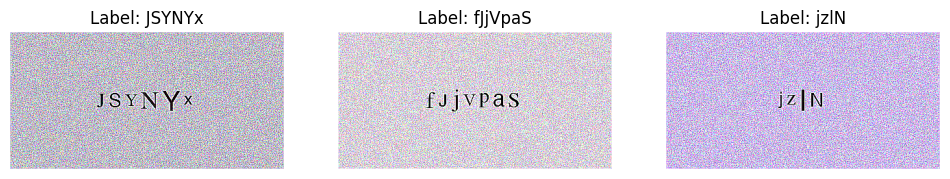


Epoch 1/30


KeyboardInterrupt: 

In [7]:
# Install necessary packages (if not already installed)
!pip install torch torchvision scikit-learn Pillow tqdm matplotlib seaborn

import os
import random
import string
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# -----------------------------------
# Beam Search Decoder for CTC (Single Sample)
# -----------------------------------
def beam_search_decoder_single(log_probs, beam_width=10, blank=0, index_to_char=None):
    """
    A simple beam search decoder for a single sample.
    Args:
        log_probs: numpy array of shape (T, num_classes) representing log probabilities.
        beam_width: beam width.
        blank: index for the blank token.
        index_to_char: dictionary mapping indices to characters.
    Returns:
        Decoded string.
    """
    T, num_classes = log_probs.shape
    beam = [("", 0.0)]  # list of (prefix, log_score)
    for t in range(T):
        new_beam = {}
        for prefix, score in beam:
            for c in range(num_classes):
                # For blank, do not append a character.
                new_prefix = prefix if c == blank else prefix + index_to_char.get(c, '')
                new_score = score + log_probs[t, c]
                if new_prefix in new_beam:
                    new_beam[new_prefix] = np.logaddexp(new_beam[new_prefix], new_score)
                else:
                    new_beam[new_prefix] = new_score
        # Keep only top beam_width candidates.
        beam = sorted(new_beam.items(), key=lambda x: x[1], reverse=True)[:beam_width]
    # Best candidate
    best = beam[0][0]
    # Remove consecutive duplicates and blanks:
    cleaned = []
    prev = None
    for char in best:
        if char == prev or char == '':
            continue
        cleaned.append(char)
        prev = char
    return ''.join(cleaned)

# -----------------------------------
# 1. Label Converter with Beam Search Option
# -----------------------------------
class LabelConverter:
    def __init__(self, alphabet):
        """
        alphabet: a string containing all valid characters.
        Index 0 is reserved for the CTC blank.
        """
        self.alphabet = alphabet
        self.char_to_index = {char: idx + 1 for idx, char in enumerate(alphabet)}
        self.index_to_char = {idx + 1: char for idx, char in enumerate(alphabet)}
        self.index_to_char[0] = ''  # blank
    
    def encode(self, texts):
        """Encode a list of texts into a target tensor and lengths tensor."""
        targets = []
        lengths = []
        for text in texts:
            encoded = [self.char_to_index[char] for char in text]
            targets.extend(encoded)
            lengths.append(len(text))
        return torch.tensor(targets, dtype=torch.long), torch.tensor(lengths, dtype=torch.long)
    
    def decode(self, preds, beam_width=0):
        """
        Decode predictions.
        Args:
            preds: Tensor of shape (T, batch, num_classes) (raw logits).
            beam_width: if >0, use beam search decoding with that width; otherwise, greedy decoding.
        Returns:
            List of decoded strings.
        """
        if beam_width == 0:
            # Greedy decoding: argmax each time step, remove duplicates and blanks.
            preds_argmax = preds.argmax(dim=2).transpose(0, 1)  # shape: (batch, T)
            results = []
            for seq in preds_argmax:
                result = []
                prev = -1
                for idx in seq.cpu().numpy().tolist():
                    if idx != prev and idx != 0:
                        result.append(self.index_to_char.get(idx, ''))
                    prev = idx
                results.append(''.join(result))
            return results
        else:
            # Beam search decoding.
            log_probs = torch.log_softmax(preds, dim=2)  # shape: (T, batch, num_classes)
            log_probs = log_probs.transpose(0, 1)  # shape: (batch, T, num_classes)
            results = []
            for sample in log_probs:
                sample_np = sample.cpu().numpy()  # shape: (T, num_classes)
                decoded = beam_search_decoder_single(sample_np, beam_width=beam_width, blank=0, index_to_char=self.index_to_char)
                results.append(decoded)
            return results

# -----------------------------------
# 2. Dataset Class for Captcha Recognition
# -----------------------------------
class CaptchaRecogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: Directory containing captcha images with filenames like "captcha_{text}_{i}.png".
        transform: torchvision transforms to apply to the PIL image.
        """
        self.root_dir = root_dir
        self.transform = transform  # We use transform=None here and apply transforms later via a wrapper.
        self.image_paths = []
        self.labels = []
        for file in os.listdir(root_dir):
            if file.endswith('.png'):
                path = os.path.join(root_dir, file)
                self.image_paths.append(path)
                base = os.path.basename(file)
                base = os.path.splitext(base)[0]
                parts = base.split('_')
                text = parts[1] if len(parts) >= 3 else ""
                self.labels.append(text)
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# -----------------------------------
# 3. CRNN Model with Additional Dropout Regularization
# -----------------------------------
class CRNN(nn.Module):
    def __init__(self, img_height, num_channels, num_classes, hidden_size=256, num_layers=2, dropout_rate=0.6):
        """
        img_height: height of input images (e.g., 64)
        num_channels: number of channels (3 for RGB)
        num_classes: number of classes (len(alphabet)+1 for CTC blank)
        hidden_size: hidden size for the LSTM
        dropout_rate: dropout probability for regularization.
        """
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # (64, img_height/2, width/2)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # (128, img_height/4, width/4)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.rnn = nn.LSTM(512, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        # Add dropout before the final fully connected layer.
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x):
        conv = self.cnn(x)
        conv = self.adaptive_pool(conv)  # shape: (batch, 512, 1, width')
        b, c, h, w = conv.size()
        assert h == 1, "Height must be 1 after pooling"
        conv = conv.squeeze(2)  # shape: (batch, 512, width')
        conv = conv.permute(0, 2, 1)  # shape: (batch, width', 512)
        rnn_out, _ = self.rnn(conv)   # shape: (batch, width', hidden_size*2)
        rnn_out = self.dropout(rnn_out)
        output = self.fc(rnn_out)     # shape: (batch, width', num_classes)
        output = output.permute(1, 0, 2)  # (T, batch, num_classes) for CTC
        return output

# -----------------------------------
# 4. Training and Validation Functions with Additional Metrics
# -----------------------------------
def train_one_epoch(model, device, train_loader, criterion, optimizer, converter, scheduler):
    model.train()
    epoch_loss = 0.0
    for images, texts in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)
        targets, target_lengths = converter.encode(texts)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)
        
        outputs = model(images)  # (T, batch, num_classes)
        T, batch_size, _ = outputs.size()
        input_lengths = torch.full((batch_size,), T, dtype=torch.long).to(device)
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Step the OneCycleLR scheduler after each batch
        
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

def validate_with_metrics(model, device, loader, criterion, converter, beam_width=0):
    model.eval()
    total_loss = 0.0
    total_words = 0
    total_correct = 0
    total_edit_distance = 0
    total_chars = 0
    all_preds = []
    all_gts = []
    
    with torch.no_grad():
        for images, texts in tqdm(loader, desc="Validation Metrics", leave=False):
            images = images.to(device)
            targets, target_lengths = converter.encode(texts)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            
            outputs = model(images)
            T, batch_size, _ = outputs.size()
            input_lengths = torch.full((batch_size,), T, dtype=torch.long).to(device)
            loss = criterion(outputs, targets, input_lengths, target_lengths)
            total_loss += loss.item() * images.size(0)
            
            preds = converter.decode(outputs, beam_width=beam_width)
            for pred, gt in zip(preds, texts):
                total_words += 1
                if pred == gt:
                    total_correct += 1
                ed = levenshtein_distance(gt, pred)
                total_edit_distance += ed
                total_chars += len(gt)
                all_preds.append(pred)
                all_gts.append(gt)
    
    avg_loss = total_loss / len(loader.dataset)
    word_acc = total_correct / total_words if total_words > 0 else 0
    avg_edit_distance = total_edit_distance / total_words if total_words > 0 else 0
    cer = total_edit_distance / total_chars if total_chars > 0 else 0
    return avg_loss, word_acc, avg_edit_distance, cer, all_preds, all_gts

def levenshtein_distance(s1, s2):
    """Compute the Levenshtein edit distance between two strings."""
    m, n = len(s1), len(s2)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
    return dp[m][n]

# -----------------------------------
# 5. Utility Function to Display Sample Images
# -----------------------------------
def show_sample_images(dataset, num_samples=3):
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        img, label = dataset[i]
        if isinstance(img, torch.Tensor):
            img_disp = img * 0.5 + 0.5  # Denormalize assuming mean=0.5 and std=0.5
            np_img = img_disp.permute(1, 2, 0).cpu().numpy()
        else:
            np_img = np.array(img)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(np_img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# -----------------------------------
# 6. Main Training Script with OneCycleLR and Increased Regularization
# -----------------------------------
if __name__ == '__main__':
    # For reproducibility.
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Data directory (ensure that captcha images exist here)
    data_dir = '/kaggle/input/hard-captcha-data-set-50k/hard_captcha_dataset'
    if not os.path.exists(data_dir):
        raise Exception(f"Data directory {data_dir} does not exist. Generate the dataset first!")
    
    # Define transforms (to be applied via a wrapper)
    train_transform = transforms.Compose([
        transforms.Resize((64, 256)),
        transforms.RandomRotation(2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    val_transform = transforms.Compose([
        transforms.Resize((64, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Create the full dataset without transforms.
    full_dataset = CaptchaRecogDataset(root_dir=data_dir, transform=None)
    print(f"Total samples in dataset: {len(full_dataset)}")
    show_sample_images(full_dataset, num_samples=3)
    
    # Split indices: 80% train, 10% validation, 10% test.
    indices = list(range(len(full_dataset)))
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    test_subset = Subset(full_dataset, test_idx)
    
    # A wrapper to apply transforms.
    class TransformedSubset(Dataset):
        def __init__(self, subset, transform):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            img, label = self.subset[index]
            if self.transform:
                img = self.transform(img)
            return img, label
        def __len__(self):
            return len(self.subset)
    
    train_dataset = TransformedSubset(train_subset, train_transform)
    val_dataset = TransformedSubset(val_subset, val_transform)
    test_dataset = TransformedSubset(test_subset, val_transform)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # Model, optimizer, and loss setup.
    alphabet = string.ascii_letters
    num_classes = len(alphabet) + 1  # extra class for CTC blank (index 0)
    converter = LabelConverter(alphabet)
    
    # Create the CRNN model with additional dropout regularization.
    model = CRNN(img_height=64, num_channels=3, num_classes=num_classes, hidden_size=256, num_layers=2, dropout_rate=0.6)
    model.to(device)
    
    criterion = nn.CTCLoss(blank=0, zero_infinity=True)
    # Base learning rate 0.001, but OneCycleLR will vary it up to max_lr.
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
    
    num_epochs = 30
    total_steps = num_epochs * len(train_loader)
    # OneCycleLR scheduler: max_lr is set higher than base (e.g., 0.005)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, total_steps=total_steps)
    
    # Lists to store metrics for plotting.
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_word_accs = []
    epoch_edit_dists = []
    epoch_cers = []
    
    # Set beam width for decoding: set to 0 for greedy or >0 for beam search (e.g., 10)
    decoding_beam_width = 10
    
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss = train_one_epoch(model, device, train_loader, criterion, optimizer, converter, scheduler)
        val_loss, word_acc, avg_edit, cer, _, _ = validate_with_metrics(model, device, val_loader, criterion, converter, beam_width=decoding_beam_width)
        
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)
        epoch_word_accs.append(word_acc)
        epoch_edit_dists.append(avg_edit)
        epoch_cers.append(cer)
        
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Word Acc: {word_acc:.4f}")
        print(f"Avg Edit Distance: {avg_edit:.4f} | CER: {cer:.4f}")
        
        # Print a few sample predictions every 5 epochs.
        if epoch % 5 == 0:
            _, _, _, _, preds, gts = validate_with_metrics(model, device, val_loader, criterion, converter, beam_width=decoding_beam_width)
            print("Sample predictions:")
            for i in range(min(3, len(preds))):
                print(f"GT: {gts[i]} | Predicted: {preds[i]}")
        
        if word_acc > best_val_acc:
            best_val_acc = word_acc
            torch.save(model.state_dict(), 'best_crnn_model.pth')
            print("Saved best model!")
    
    # -----------------------------------
    # Plot Training Curves and Metrics
    # -----------------------------------
    epochs_range = range(1, num_epochs+1)
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2,2,1)
    plt.plot(epochs_range, epoch_train_losses, label='Train Loss')
    plt.plot(epochs_range, epoch_val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.plot(epochs_range, epoch_word_accs, label='Val Word Accuracy', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Word Accuracy")
    plt.title("Word Accuracy")
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.plot(epochs_range, epoch_edit_dists, label='Avg Edit Distance', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Edit Distance")
    plt.title("Average Edit Distance")
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.plot(epochs_range, epoch_cers, label='CER', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("CER")
    plt.title("Character Error Rate")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # -----------------------------------
    # Final Evaluation on Test Set
    # -----------------------------------
    model.load_state_dict(torch.load('best_crnn_model.pth'))
    test_loss, test_word_acc, test_avg_edit, test_cer, test_preds, test_gts = validate_with_metrics(
        model, device, test_loader, criterion, converter, beam_width=decoding_beam_width)
    
    print(f"\nFinal Test Loss: {test_loss:.4f}")
    print(f"Test Word Accuracy: {test_word_acc:.4f}")
    print(f"Test Avg Edit Distance: {test_avg_edit:.4f}")
    print(f"Test CER: {test_cer:.4f}")
    
    # Plot histogram of edit distances for test set.
    edit_dists = [levenshtein_distance(gt, pred) for gt, pred in zip(test_gts, test_preds)]
    plt.figure(figsize=(6,4))
    plt.hist(edit_dists, bins=range(0, max(edit_dists)+2), edgecolor='black', align='left')
    plt.xlabel("Edit Distance")
    plt.ylabel("Number of Samples")
    plt.title("Edit Distance Distribution on Test Set")
    plt.show()
    
    print("\nSample Test Predictions:")
    for i in range(min(10, len(test_preds))):
        print(f"GT: {test_gts[i]} | Predicted: {test_preds[i]}")
    
    # Compute and display a character-level confusion matrix (only for samples with equal-length predictions).
    gt_chars = []
    pred_chars = []
    for gt, pred in zip(test_gts, test_preds):
        if len(gt) == len(pred) and len(gt) > 0:
            gt_chars.extend(list(gt))
            pred_chars.extend(list(pred))
    if gt_chars and pred_chars:
        labels = list(alphabet)
        cm = confusion_matrix(gt_chars, pred_chars, labels=labels)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Character")
        plt.ylabel("Ground Truth Character")
        plt.title("Character-level Confusion Matrix")
        plt.show()
    else:
        print("Not enough samples for confusion matrix computation.")


# changing optimising parameters

Total samples in dataset: 50000


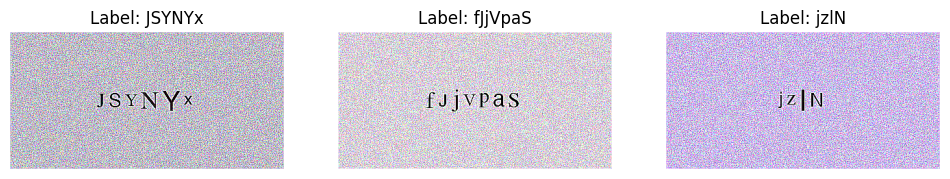


Epoch 1/30


Train Loss: 4.3435 | Val Loss: 4.4624 | Val Word Acc: 0.0000
Avg Edit Distance: 6.2796 | CER: 1.0000


Sample predictions:
GT: nBHqC | Predicted: 
GT: nRCBU | Predicted: 
GT: QkFCG | Predicted: 

Epoch 2/30


Train Loss: 2.8189 | Val Loss: 0.8047 | Val Word Acc: 0.3002
Avg Edit Distance: 1.1008 | CER: 0.1753
Saved best model!

Epoch 3/30


Train Loss: 0.3396 | Val Loss: 0.2616 | Val Word Acc: 0.8016
Avg Edit Distance: 0.2168 | CER: 0.0345
Saved best model!

Epoch 4/30


Train Loss: 0.1099 | Val Loss: 0.0079 | Val Word Acc: 0.7994
Avg Edit Distance: 0.2220 | CER: 0.0354

Epoch 5/30


Train Loss: 0.0891 | Val Loss: 0.1635 | Val Word Acc: 0.8020
Avg Edit Distance: 0.2198 | CER: 0.0350
Saved best model!

Epoch 6/30


Train Loss: 0.0905 | Val Loss: 0.0986 | Val Word Acc: 0.8390
Avg Edit Distance: 0.1760 | CER: 0.0280


Sample predictions:
GT: nBHqC | Predicted: nBHqC
GT: nRCBU | Predicted: nRCBU
GT: QkFCG | Predicted: QkFCG
Saved best model!

Epoch 7/30


Train Loss: 0.0927 | Val Loss: 0.1527 | Val Word Acc: 0.7526
Avg Edit Distance: 0.2754 | CER: 0.0439

Epoch 8/30


Train Loss: 0.1078 | Val Loss: 0.1586 | Val Word Acc: 0.7466
Avg Edit Distance: 0.2826 | CER: 0.0450

Epoch 9/30


Train Loss: 0.1266 | Val Loss: 0.1409 | Val Word Acc: 0.7250
Avg Edit Distance: 0.3180 | CER: 0.0506

Epoch 10/30


Train Loss: 0.1460 | Val Loss: 0.2524 | Val Word Acc: 0.7270
Avg Edit Distance: 0.3086 | CER: 0.0491

Epoch 11/30


Train Loss: 0.1218 | Val Loss: 0.6494 | Val Word Acc: 0.4048
Avg Edit Distance: 0.8862 | CER: 0.1411

Epoch 13/30


Train Loss: 0.1504 | Val Loss: 0.1395 | Val Word Acc: 0.8206
Avg Edit Distance: 0.1946 | CER: 0.0310

Epoch 14/30


Train Loss: 0.1130 | Val Loss: 0.2915 | Val Word Acc: 0.7460
Avg Edit Distance: 0.2868 | CER: 0.0457

Epoch 15/30


Train Loss: 0.1193 | Val Loss: 0.1281 | Val Word Acc: 0.8136
Avg Edit Distance: 0.2024 | CER: 0.0322

Epoch 16/30


Train Loss: 0.0992 | Val Loss: 0.0296 | Val Word Acc: 0.8582
Avg Edit Distance: 0.1520 | CER: 0.0242


Sample predictions:
GT: nBHqC | Predicted: nBHqC
GT: nRCBU | Predicted: nRCBU
GT: QkFCG | Predicted: QkFCG
Saved best model!

Epoch 17/30


Train Loss: 0.1001 | Val Loss: 0.0643 | Val Word Acc: 0.8442
Avg Edit Distance: 0.1666 | CER: 0.0265

Epoch 18/30


Train Loss: 0.0837 | Val Loss: 0.0477 | Val Word Acc: 0.8552
Avg Edit Distance: 0.1552 | CER: 0.0247

Epoch 19/30


Train Loss: 0.0726 | Val Loss: 0.0164 | Val Word Acc: 0.8440
Avg Edit Distance: 0.1688 | CER: 0.0269

Epoch 20/30


Train Loss: 0.0533 | Val Loss: 0.0355 | Val Word Acc: 0.8552
Avg Edit Distance: 0.1540 | CER: 0.0245

Epoch 21/30


Train Loss: 0.0529 | Val Loss: 0.0361 | Val Word Acc: 0.8578
Avg Edit Distance: 0.1510 | CER: 0.0240


Sample predictions:
GT: nBHqC | Predicted: nBHqC
GT: nRCBU | Predicted: nRCBU
GT: QkFCG | Predicted: QkFCG

Epoch 22/30


Train Loss: 0.0360 | Val Loss: 0.0095 | Val Word Acc: 0.8710
Avg Edit Distance: 0.1370 | CER: 0.0218
Saved best model!

Epoch 23/30


Train Loss: 0.0331 | Val Loss: 0.0206 | Val Word Acc: 0.8752
Avg Edit Distance: 0.1322 | CER: 0.0211
Saved best model!

Epoch 24/30


Train Loss: 0.0267 | Val Loss: 0.0125 | Val Word Acc: 0.8792
Avg Edit Distance: 0.1268 | CER: 0.0202
Saved best model!

Epoch 25/30


Train Loss: 0.0229 | Val Loss: 0.0111 | Val Word Acc: 0.8764
Avg Edit Distance: 0.1306 | CER: 0.0208

Epoch 26/30


Train Loss: 0.0207 | Val Loss: 0.0228 | Val Word Acc: 0.8828
Avg Edit Distance: 0.1238 | CER: 0.0197


Sample predictions:
GT: nBHqC | Predicted: nBHqC
GT: nRCBU | Predicted: nRCBU
GT: QkFCG | Predicted: QkFCG
Saved best model!

Epoch 27/30


Train Loss: 0.0174 | Val Loss: 0.0163 | Val Word Acc: 0.8856
Avg Edit Distance: 0.1208 | CER: 0.0192
Saved best model!

Epoch 28/30


Train Loss: 0.0155 | Val Loss: 0.0131 | Val Word Acc: 0.8868
Avg Edit Distance: 0.1192 | CER: 0.0190
Saved best model!

Epoch 29/30


Train Loss: 0.0139 | Val Loss: 0.0118 | Val Word Acc: 0.8872
Avg Edit Distance: 0.1186 | CER: 0.0189
Saved best model!

Epoch 30/30


Train Loss: 0.0138 | Val Loss: 0.0116 | Val Word Acc: 0.8876
Avg Edit Distance: 0.1182 | CER: 0.0188
Saved best model!


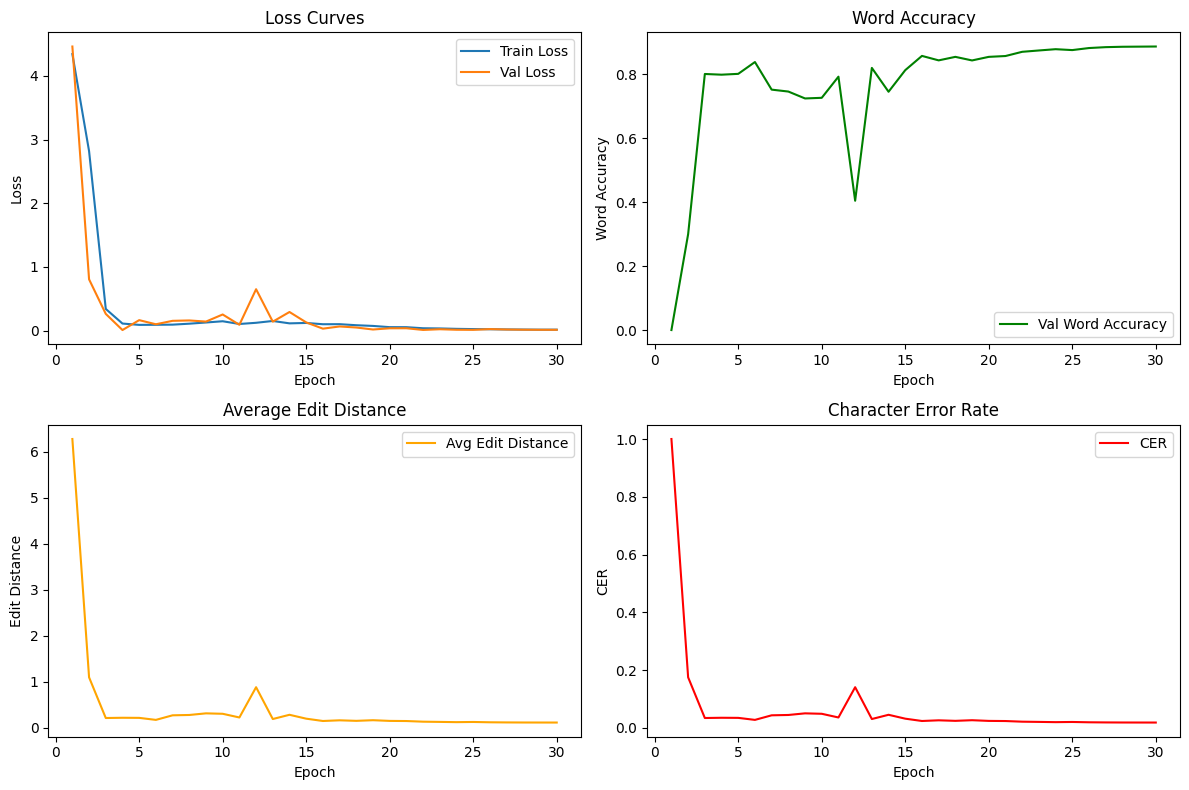

<ipython-input-8-cce88d9e41bd>:467: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_crnn_model.pth'))



Final Test Loss: 0.0126
Test Word Accuracy: 0.8824
Test Avg Edit Distance: 0.1256
Test CER: 0.0199


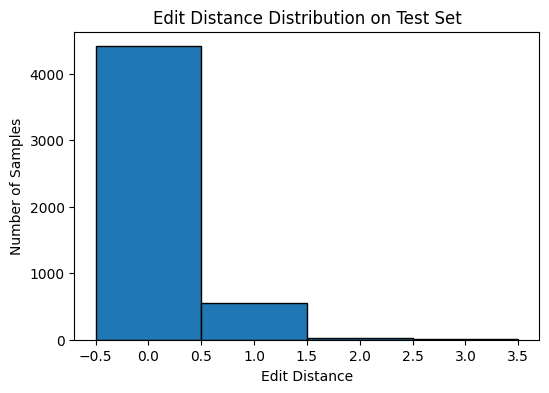


Sample Test Predictions:
GT: kVnMvXn | Predicted: kVnMvXn
GT: QDhd | Predicted: QDhd
GT: ynmJRVnG | Predicted: ynmJRVnG
GT: zQIJFEt | Predicted: zQIJFEt
GT: yUNKuovLP | Predicted: yUNKuovLP
GT: DsZGGv | Predicted: DsZGv
GT: BnicF | Predicted: BnicF
GT: pgvqo | Predicted: pgvqo
GT: FosKFYS | Predicted: FosKFYS
GT: jeTybX | Predicted: jeTybX


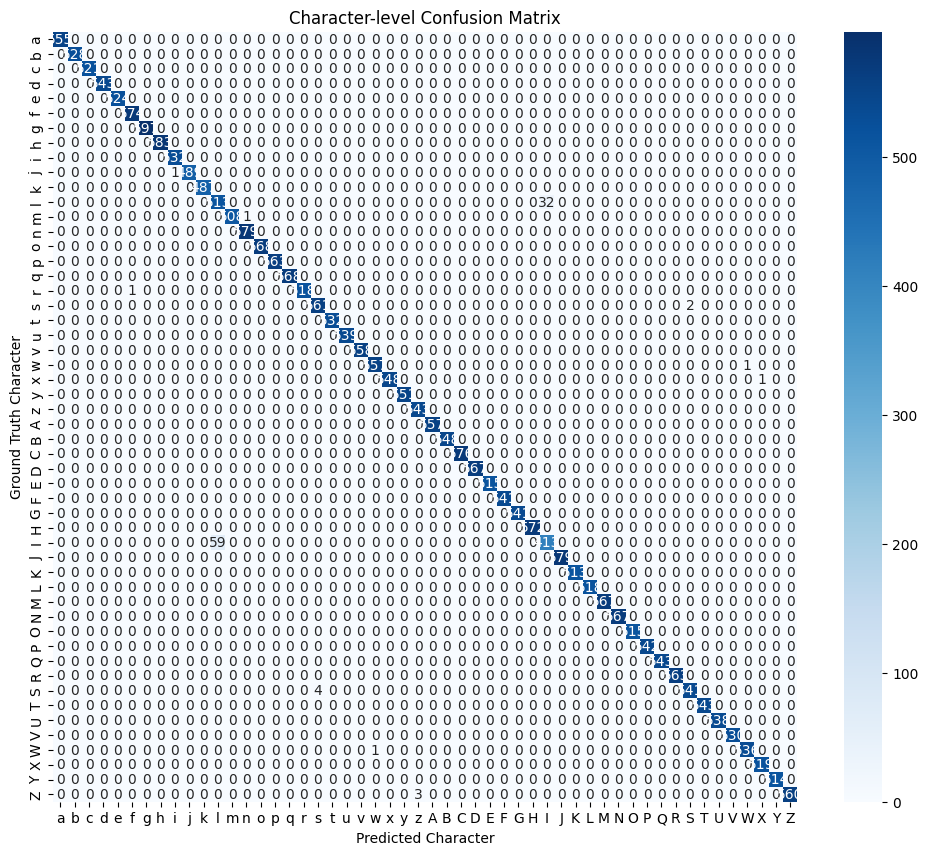

In [8]:
# Install necessary packages (if not already installed)
!pip install torch torchvision scikit-learn Pillow tqdm matplotlib seaborn

import os
import random
import string
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# -----------------------------------
# Beam Search Decoder for CTC (Single Sample)
# -----------------------------------
def beam_search_decoder_single(log_probs, beam_width=10, blank=0, index_to_char=None):
    """
    A simple beam search decoder for a single sample.
    Args:
        log_probs: numpy array of shape (T, num_classes) representing log probabilities.
        beam_width: beam width.
        blank: index for the blank token.
        index_to_char: dictionary mapping indices to characters.
    Returns:
        Decoded string.
    """
    T, num_classes = log_probs.shape
    beam = [("", 0.0)]  # list of (prefix, log_score)
    for t in range(T):
        new_beam = {}
        for prefix, score in beam:
            for c in range(num_classes):
                # For blank, do not append a character.
                new_prefix = prefix if c == blank else prefix + index_to_char.get(c, '')
                new_score = score + log_probs[t, c]
                if new_prefix in new_beam:
                    new_beam[new_prefix] = np.logaddexp(new_beam[new_prefix], new_score)
                else:
                    new_beam[new_prefix] = new_score
        # Keep only top beam_width candidates.
        beam = sorted(new_beam.items(), key=lambda x: x[1], reverse=True)[:beam_width]
    # Best candidate
    best = beam[0][0]
    # Remove consecutive duplicates and blanks:
    cleaned = []
    prev = None
    for char in best:
        if char == prev or char == '':
            continue
        cleaned.append(char)
        prev = char
    return ''.join(cleaned)

# -----------------------------------
# 1. Label Converter with Beam Search Option
# -----------------------------------
class LabelConverter:
    def __init__(self, alphabet):
        """
        alphabet: a string containing all valid characters.
        Index 0 is reserved for the CTC blank.
        """
        self.alphabet = alphabet
        self.char_to_index = {char: idx + 1 for idx, char in enumerate(alphabet)}
        self.index_to_char = {idx + 1: char for idx, char in enumerate(alphabet)}
        self.index_to_char[0] = ''  # blank
    
    def encode(self, texts):
        """Encode a list of texts into a target tensor and lengths tensor."""
        targets = []
        lengths = []
        for text in texts:
            encoded = [self.char_to_index[char] for char in text]
            targets.extend(encoded)
            lengths.append(len(text))
        return torch.tensor(targets, dtype=torch.long), torch.tensor(lengths, dtype=torch.long)
    
    def decode(self, preds, beam_width=0):
        """
        Decode predictions.
        Args:
            preds: Tensor of shape (T, batch, num_classes) (raw logits).
            beam_width: if >0, use beam search decoding with that width; otherwise, greedy decoding.
        Returns:
            List of decoded strings.
        """
        if beam_width == 0:
            # Greedy decoding: argmax each time step, remove duplicates and blanks.
            preds_argmax = preds.argmax(dim=2).transpose(0, 1)  # shape: (batch, T)
            results = []
            for seq in preds_argmax:
                result = []
                prev = -1
                for idx in seq.cpu().numpy().tolist():
                    if idx != prev and idx != 0:
                        result.append(self.index_to_char.get(idx, ''))
                    prev = idx
                results.append(''.join(result))
            return results
        else:
            # Beam search decoding.
            log_probs = torch.log_softmax(preds, dim=2)  # shape: (T, batch, num_classes)
            log_probs = log_probs.transpose(0, 1)  # shape: (batch, T, num_classes)
            results = []
            for sample in log_probs:
                sample_np = sample.cpu().numpy()  # shape: (T, num_classes)
                decoded = beam_search_decoder_single(sample_np, beam_width=beam_width, blank=0, index_to_char=self.index_to_char)
                results.append(decoded)
            return results

# -----------------------------------
# 2. Dataset Class for Captcha Recognition
# -----------------------------------
class CaptchaRecogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: Directory containing captcha images with filenames like "captcha_{text}_{i}.png".
        transform: torchvision transforms to apply to the PIL image.
        """
        self.root_dir = root_dir
        self.transform = transform  # We use transform=None here and apply transforms later via a wrapper.
        self.image_paths = []
        self.labels = []
        for file in os.listdir(root_dir):
            if file.endswith('.png'):
                path = os.path.join(root_dir, file)
                self.image_paths.append(path)
                base = os.path.basename(file)
                base = os.path.splitext(base)[0]
                parts = base.split('_')
                text = parts[1] if len(parts) >= 3 else ""
                self.labels.append(text)
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# -----------------------------------
# 3. CRNN Model with Additional Dropout Regularization
# -----------------------------------
class CRNN(nn.Module):
    def __init__(self, img_height, num_channels, num_classes, hidden_size=256, num_layers=2, dropout_rate=0.6):
        """
        img_height: height of input images (e.g., 64)
        num_channels: number of channels (3 for RGB)
        num_classes: number of classes (len(alphabet)+1 for CTC blank)
        hidden_size: hidden size for the LSTM
        dropout_rate: dropout probability for regularization.
        """
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # (64, img_height/2, width/2)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # (128, img_height/4, width/4)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.rnn = nn.LSTM(512, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        # Add dropout before the final fully connected layer.
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x):
        conv = self.cnn(x)
        conv = self.adaptive_pool(conv)  # shape: (batch, 512, 1, width')
        b, c, h, w = conv.size()
        assert h == 1, "Height must be 1 after pooling"
        conv = conv.squeeze(2)  # shape: (batch, 512, width')
        conv = conv.permute(0, 2, 1)  # shape: (batch, width', 512)
        rnn_out, _ = self.rnn(conv)   # shape: (batch, width', hidden_size*2)
        rnn_out = self.dropout(rnn_out)
        output = self.fc(rnn_out)     # shape: (batch, width', num_classes)
        output = output.permute(1, 0, 2)  # (T, batch, num_classes) for CTC
        return output

# -----------------------------------
# 4. Training and Validation Functions with Additional Metrics
# -----------------------------------
def train_one_epoch(model, device, train_loader, criterion, optimizer, converter, scheduler):
    model.train()
    epoch_loss = 0.0
    for images, texts in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)
        targets, target_lengths = converter.encode(texts)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)
        
        outputs = model(images)  # (T, batch, num_classes)
        T, batch_size, _ = outputs.size()
        input_lengths = torch.full((batch_size,), T, dtype=torch.long).to(device)
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

        optimizer.step()
        scheduler.step()  # Step the OneCycleLR scheduler after each batch
        
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

def validate_with_metrics(model, device, loader, criterion, converter, beam_width=0):
    model.eval()
    total_loss = 0.0
    total_words = 0
    total_correct = 0
    total_edit_distance = 0
    total_chars = 0
    all_preds = []
    all_gts = []
    
    with torch.no_grad():
        for images, texts in tqdm(loader, desc="Validation Metrics", leave=False):
            images = images.to(device)
            targets, target_lengths = converter.encode(texts)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            
            outputs = model(images)
            T, batch_size, _ = outputs.size()
            input_lengths = torch.full((batch_size,), T, dtype=torch.long).to(device)
            loss = criterion(outputs, targets, input_lengths, target_lengths)
            total_loss += loss.item() * images.size(0)
            
            preds = converter.decode(outputs, beam_width=beam_width)
            for pred, gt in zip(preds, texts):
                total_words += 1
                if pred == gt:
                    total_correct += 1
                ed = levenshtein_distance(gt, pred)
                total_edit_distance += ed
                total_chars += len(gt)
                all_preds.append(pred)
                all_gts.append(gt)
    
    avg_loss = total_loss / len(loader.dataset)
    word_acc = total_correct / total_words if total_words > 0 else 0
    avg_edit_distance = total_edit_distance / total_words if total_words > 0 else 0
    cer = total_edit_distance / total_chars if total_chars > 0 else 0
    return avg_loss, word_acc, avg_edit_distance, cer, all_preds, all_gts

def levenshtein_distance(s1, s2):
    """Compute the Levenshtein edit distance between two strings."""
    m, n = len(s1), len(s2)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
    return dp[m][n]

# -----------------------------------
# 5. Utility Function to Display Sample Images
# -----------------------------------
def show_sample_images(dataset, num_samples=3):
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        img, label = dataset[i]
        if isinstance(img, torch.Tensor):
            img_disp = img * 0.5 + 0.5  # Denormalize assuming mean=0.5 and std=0.5
            np_img = img_disp.permute(1, 2, 0).cpu().numpy()
        else:
            np_img = np.array(img)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(np_img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# -----------------------------------
# 6. Main Training Script with OneCycleLR and Increased Regularization
# -----------------------------------
if __name__ == '__main__':
    # For reproducibility.
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Data directory (ensure that captcha images exist here)
    data_dir = '/kaggle/input/hard-captcha-data-set-50k/hard_captcha_dataset'
    if not os.path.exists(data_dir):
        raise Exception(f"Data directory {data_dir} does not exist. Generate the dataset first!")
    
    # Define transforms (to be applied via a wrapper)
    train_transform = transforms.Compose([
        transforms.Resize((64, 256)),
        transforms.RandomRotation(2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    val_transform = transforms.Compose([
        transforms.Resize((64, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Create the full dataset without transforms.
    full_dataset = CaptchaRecogDataset(root_dir=data_dir, transform=None)
    print(f"Total samples in dataset: {len(full_dataset)}")
    show_sample_images(full_dataset, num_samples=3)
    
    # Split indices: 80% train, 10% validation, 10% test.
    indices = list(range(len(full_dataset)))
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    test_subset = Subset(full_dataset, test_idx)
    
    # A wrapper to apply transforms.
    class TransformedSubset(Dataset):
        def __init__(self, subset, transform):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            img, label = self.subset[index]
            if self.transform:
                img = self.transform(img)
            return img, label
        def __len__(self):
            return len(self.subset)
    
    train_dataset = TransformedSubset(train_subset, train_transform)
    val_dataset = TransformedSubset(val_subset, val_transform)
    test_dataset = TransformedSubset(test_subset, val_transform)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # Model, optimizer, and loss setup.
    alphabet = string.ascii_letters
    num_classes = len(alphabet) + 1  # extra class for CTC blank (index 0)
    converter = LabelConverter(alphabet)
    
    # Create the CRNN model with additional dropout regularization.
    model = CRNN(img_height=64, num_channels=3, num_classes=num_classes, hidden_size=256, num_layers=2, dropout_rate=0.6)
    model.to(device)
    
    criterion = nn.CTCLoss(blank=0, zero_infinity=True)
    # Base learning rate 0.001, but OneCycleLR will vary it up to max_lr.
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
    
    num_epochs = 30
    total_steps = num_epochs * len(train_loader)
    # OneCycleLR scheduler: max_lr is set higher than base (e.g., 0.005)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.003, total_steps=total_steps)
    
    # Lists to store metrics for plotting.
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_word_accs = []
    epoch_edit_dists = []
    epoch_cers = []
    
    # Set beam width for decoding: set to 0 for greedy or >0 for beam search (e.g., 10)
    decoding_beam_width = 10
    
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss = train_one_epoch(model, device, train_loader, criterion, optimizer, converter, scheduler)
        val_loss, word_acc, avg_edit, cer, _, _ = validate_with_metrics(model, device, val_loader, criterion, converter, beam_width=decoding_beam_width)
        
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)
        epoch_word_accs.append(word_acc)
        epoch_edit_dists.append(avg_edit)
        epoch_cers.append(cer)
        
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Word Acc: {word_acc:.4f}")
        print(f"Avg Edit Distance: {avg_edit:.4f} | CER: {cer:.4f}")
        
        # Print a few sample predictions every 5 epochs.
        if epoch % 5 == 0:
            _, _, _, _, preds, gts = validate_with_metrics(model, device, val_loader, criterion, converter, beam_width=decoding_beam_width)
            print("Sample predictions:")
            for i in range(min(3, len(preds))):
                print(f"GT: {gts[i]} | Predicted: {preds[i]}")
        
        if word_acc > best_val_acc:
            best_val_acc = word_acc
            torch.save(model.state_dict(), 'best_crnn_model.pth')
            print("Saved best model!")
    
    # -----------------------------------
    # Plot Training Curves and Metrics
    # -----------------------------------
    epochs_range = range(1, num_epochs+1)
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2,2,1)
    plt.plot(epochs_range, epoch_train_losses, label='Train Loss')
    plt.plot(epochs_range, epoch_val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.plot(epochs_range, epoch_word_accs, label='Val Word Accuracy', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Word Accuracy")
    plt.title("Word Accuracy")
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.plot(epochs_range, epoch_edit_dists, label='Avg Edit Distance', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Edit Distance")
    plt.title("Average Edit Distance")
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.plot(epochs_range, epoch_cers, label='CER', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("CER")
    plt.title("Character Error Rate")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # -----------------------------------
    # Final Evaluation on Test Set
    # -----------------------------------
    model.load_state_dict(torch.load('best_crnn_model.pth'))
    test_loss, test_word_acc, test_avg_edit, test_cer, test_preds, test_gts = validate_with_metrics(
        model, device, test_loader, criterion, converter, beam_width=decoding_beam_width)
    
    print(f"\nFinal Test Loss: {test_loss:.4f}")
    print(f"Test Word Accuracy: {test_word_acc:.4f}")
    print(f"Test Avg Edit Distance: {test_avg_edit:.4f}")
    print(f"Test CER: {test_cer:.4f}")
    
    # Plot histogram of edit distances for test set.
    edit_dists = [levenshtein_distance(gt, pred) for gt, pred in zip(test_gts, test_preds)]
    plt.figure(figsize=(6,4))
    plt.hist(edit_dists, bins=range(0, max(edit_dists)+2), edgecolor='black', align='left')
    plt.xlabel("Edit Distance")
    plt.ylabel("Number of Samples")
    plt.title("Edit Distance Distribution on Test Set")
    plt.show()
    
    print("\nSample Test Predictions:")
    for i in range(min(10, len(test_preds))):
        print(f"GT: {test_gts[i]} | Predicted: {test_preds[i]}")
    
    # Compute and display a character-level confusion matrix (only for samples with equal-length predictions).
    gt_chars = []
    pred_chars = []
    for gt, pred in zip(test_gts, test_preds):
        if len(gt) == len(pred) and len(gt) > 0:
            gt_chars.extend(list(gt))
            pred_chars.extend(list(pred))
    if gt_chars and pred_chars:
        labels = list(alphabet)
        cm = confusion_matrix(gt_chars, pred_chars, labels=labels)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Character")
        plt.ylabel("Ground Truth Character")
        plt.title("Character-level Confusion Matrix")
        plt.show()
    else:
        print("Not enough samples for confusion matrix computation.")


# Attention mechanism implemented 

In [3]:
# Install required packages (if not already installed)
!pip install torch torchvision scikit-learn Pillow tqdm matplotlib seaborn

import os
import random
import string
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

##############################################
# 1. Vocabulary and Label Conversion for Seq2Seq
##############################################

PAD_token = '<pad>'
SOS_token = '<sos>'
EOS_token = '<eos>'
alphabet = list(string.ascii_letters)  # all upper- and lower-case letters
vocab = [PAD_token, SOS_token, EOS_token] + alphabet
vocab_size = len(vocab)

class SeqLabelConverter:
    """
    Converts text strings to lists of token indices and vice versa.
    Automatically adds <sos> at the beginning and <eos> at the end.
    """
    def __init__(self, vocab):
        self.vocab = vocab
        self.char_to_index = {char: idx for idx, char in enumerate(vocab)}
        self.index_to_char = {idx: char for idx, char in enumerate(vocab)}
    
    def encode(self, texts):
        sequences = []
        for text in texts:
            seq = [self.char_to_index[SOS_token]]
            for ch in text:
                if ch in self.char_to_index:
                    seq.append(self.char_to_index[ch])
            seq.append(self.char_to_index[EOS_token])
            sequences.append(seq)
        return sequences
    
    def decode(self, sequences):
        texts = []
        for seq in sequences:
            s = []
            for idx in seq:
                if idx == self.char_to_index[EOS_token]:
                    break
                if idx == self.char_to_index[SOS_token]:
                    continue
                s.append(self.index_to_char[idx])
            texts.append(''.join(s))
        return texts

converter = SeqLabelConverter(vocab)

##############################################
# 2. Dataset and Collate Function
##############################################

class CaptchaRecogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for file in os.listdir(root_dir):
            if file.endswith('.png'):
                path = os.path.join(root_dir, file)
                self.image_paths.append(path)
                base = os.path.basename(file)
                base = os.path.splitext(base)[0]
                parts = base.split('_')
                text = parts[1] if len(parts) >= 3 else ""
                self.labels.append(text)
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

def collate_fn(batch):
    images, texts = zip(*batch)
    images = torch.stack(images, dim=0)
    seqs = converter.encode(texts)
    seq_tensors = [torch.tensor(seq, dtype=torch.long) for seq in seqs]
    padded_seqs = pad_sequence(seq_tensors, batch_first=True, padding_value=converter.char_to_index[PAD_token])
    return images, padded_seqs

##############################################
# 3. Encoder (CNN + BiLSTM)
##############################################

class Encoder(nn.Module):
    def __init__(self, img_height, num_channels, enc_hidden_size):
        super(Encoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.lstm = nn.LSTM(512, enc_hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        
    def forward(self, x):
        conv = self.cnn(x)                      # (batch, 512, new_height, new_width)
        conv = self.adaptive_pool(conv)         # (batch, 512, 1, new_width)
        conv = conv.squeeze(2)                  # (batch, 512, new_width)
        conv = conv.permute(0, 2, 1)              # (batch, new_width, 512)
        outputs, _ = self.lstm(conv)            # (batch, new_width, 2*enc_hidden_size)
        return outputs

##############################################
# 4. Attention Mechanism (Bahdanau)
##############################################

class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(enc_dim + dec_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)
    
    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

##############################################
# 5. Decoder with Attention
##############################################

class DecoderWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dec_hidden_size, enc_dim, attn_dim, dropout=0.5):
        super(DecoderWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=converter.char_to_index[PAD_token])
        self.attention = Attention(enc_dim, dec_hidden_size, attn_dim)
        self.lstm = nn.LSTM(embedding_dim + enc_dim, dec_hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(dec_hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)  # (batch, 1)
        embedded = self.dropout(self.embedding(input))  # (batch, 1, embedding_dim)
        attn_weights = self.attention(hidden.squeeze(0), encoder_outputs)  # (batch, seq_len)
        attn_weights = attn_weights.unsqueeze(1)  # (batch, 1, seq_len)
        context = torch.bmm(attn_weights, encoder_outputs)  # (batch, 1, enc_dim)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell, attn_weights.squeeze(1)

##############################################
# 6. Seq2Seq Model with Attention
##############################################

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, max_length=20):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.max_length = max_length
    
    def forward(self, images, target_seqs=None, teacher_forcing_ratio=0.5):
        batch_size = images.size(0)
        if target_seqs is not None:
            target_len = target_seqs.size(1)
        else:
            target_len = self.max_length
        vocab_size = self.decoder.embedding.num_embeddings
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
        encoder_outputs = self.encoder(images)
        dec_hidden = torch.zeros(1, batch_size, self.decoder.lstm.hidden_size).to(self.device)
        dec_cell = torch.zeros(1, batch_size, self.decoder.lstm.hidden_size).to(self.device)
        input = torch.LongTensor([converter.char_to_index[SOS_token]] * batch_size).to(self.device)
        for t in range(target_len):
            output, dec_hidden, dec_cell, _ = self.decoder(input, dec_hidden, dec_cell, encoder_outputs)
            outputs[:, t, :] = output
            teacher_force = (target_seqs is not None) and (random.random() < teacher_forcing_ratio)
            top1 = output.argmax(1)
            input = target_seqs[:, t] if teacher_force else top1
        return outputs

    def inference(self, images):
        # Greedy decoding (already implemented).
        batch_size = images.size(0)
        vocab_size = self.decoder.embedding.num_embeddings
        outputs = []
        encoder_outputs = self.encoder(images)
        dec_hidden = torch.zeros(1, batch_size, self.decoder.lstm.hidden_size).to(self.device)
        dec_cell = torch.zeros(1, batch_size, self.decoder.lstm.hidden_size).to(self.device)
        input = torch.LongTensor([converter.char_to_index[SOS_token]] * batch_size).to(self.device)
        for t in range(self.max_length):
            output, dec_hidden, dec_cell, _ = self.decoder(input, dec_hidden, dec_cell, encoder_outputs)
            top1 = output.argmax(1)
            outputs.append(top1.unsqueeze(1))
            input = top1
        outputs = torch.cat(outputs, dim=1)
        return outputs

    def inference_beam(self, images, beam_width=3):
        """
        Beam search decoding for each sample in the batch.
        Returns a list of sequences (list of token indices) for each sample.
        """
        self.eval()
        encoder_outputs = self.encoder(images)  # (batch, seq_len, enc_dim)
        batch_size = images.size(0)
        results = []
        for i in range(batch_size):
            enc_out = encoder_outputs[i:i+1]  # (1, seq_len, enc_dim)
            dec_hidden = torch.zeros(1, 1, self.decoder.lstm.hidden_size).to(self.device)
            dec_cell = torch.zeros(1, 1, self.decoder.lstm.hidden_size).to(self.device)
            # Initial token is SOS.
            init_token = converter.char_to_index[SOS_token]
            beam = [([init_token], dec_hidden, dec_cell, 0.0)]
            for t in range(self.max_length):
                new_beam = []
                for seq, hidden, cell, score in beam:
                    # If EOS is reached, carry the candidate forward unchanged.
                    if seq[-1] == converter.char_to_index[EOS_token]:
                        new_beam.append((seq, hidden, cell, score))
                    else:
                        current_token = torch.LongTensor([seq[-1]]).to(self.device)
                        logits, new_hidden, new_cell, _ = self.decoder(current_token, hidden, cell, enc_out)
                        log_probs = F.log_softmax(logits, dim=1)  # (1, vocab_size)
                        log_probs = log_probs.squeeze(0)  # (vocab_size,)
                        for token in range(vocab_size):
                            new_seq = seq + [token]
                            new_score = score + log_probs[token].item()
                            new_beam.append((new_seq, new_hidden, new_cell, new_score))
                beam = sorted(new_beam, key=lambda x: x[3], reverse=True)[:beam_width]
            best_seq = beam[0][0]
            results.append(best_seq)
        return results

##############################################
# 7. Training and Evaluation Utilities
##############################################

def train_epoch(model, device, loader, criterion, optimizer, scheduler, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0.0
    for images, target_seqs in tqdm(loader, desc="Training", leave=False):
        
        images = images.to(device)
        target_seqs = target_seqs.to(device)
        optimizer.zero_grad()
        outputs = model(images, target_seqs, teacher_forcing_ratio)
        outputs = outputs.view(-1, vocab_size)
        targets = target_seqs.view(-1)
        loss = criterion(outputs, targets)
        
        loss.backward()
        # Optional: Gradient clipping can be applied here.
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        if random.randint(1, 150) == 1:  # 1 in 100 chance
            print(f"Gradient Norm: {grad_norm}")
        optimizer.step()
        #scheduler.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, device, loader, criterion, use_beam=False, beam_width=3):
    model.eval()
    epoch_loss = 0.0
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for images, target_seqs in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(device)
            target_seqs = target_seqs.to(device)
            outputs = model(images, target_seqs, teacher_forcing_ratio=0.0)
            outputs_flat = outputs.view(-1, vocab_size)
            targets_flat = target_seqs.view(-1)
            loss = criterion(outputs_flat, targets_flat)
            epoch_loss += loss.item()
            if use_beam:
                pred_indices = model.inference_beam(images, beam_width=beam_width)
            else:
                pred_indices = model.inference(images).cpu().tolist()
            preds = converter.decode(pred_indices)
            gts = converter.decode(target_seqs.cpu().tolist())
            all_preds.extend(preds)
            all_gts.extend(gts)
    return epoch_loss / len(loader), all_preds, all_gts

def levenshtein_distance(s1, s2):
    m, n = len(s1), len(s2)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
    return dp[m][n]

def compute_metrics(preds, gts):
    total_words = len(gts)
    correct_words = sum([1 for p, gt in zip(preds, gts) if p == gt])
    word_acc = correct_words / total_words if total_words > 0 else 0
    total_edit_distance = 0
    total_chars = 0
    for gt, p in zip(gts, preds):
        ed = levenshtein_distance(gt, p)
        total_edit_distance += ed
        total_chars += len(gt)
    avg_edit_distance = total_edit_distance / total_words if total_words > 0 else 0
    cer = total_edit_distance / total_chars if total_chars > 0 else 0
    return word_acc, avg_edit_distance, cer

##############################################
# 8. Transforms, Dataset, and DataLoader Setup
##############################################

train_transform = transforms.Compose([
    transforms.Resize((64, 256)),
    # transforms.RandomRotation(2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
val_transform = transforms.Compose([
    transforms.Resize((64,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

data_dir = '/kaggle/input/hard-captcha-data-set-50k/hard_captcha_dataset'
if not os.path.exists(data_dir):
    raise Exception(f"Data directory {data_dir} does not exist. Generate the dataset first!")
full_dataset = CaptchaRecogDataset(root_dir=data_dir, transform=train_transform)
print(f"Total samples in dataset: {len(full_dataset)}")
indices = list(range(len(full_dataset)))
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_subset = Subset(full_dataset, test_idx)
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)

##############################################
# 9. Model, Optimizer, and Scheduler Setup
##############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc_hidden_size = 256
embedding_dim = 128
dec_hidden_size = 256
attn_dim = 256
dropout = 0.6
max_length = 20

encoder = Encoder(img_height=64, num_channels=3, enc_hidden_size=enc_hidden_size)
decoder = DecoderWithAttention(vocab_size=vocab_size, embedding_dim=embedding_dim, 
                                 dec_hidden_size=dec_hidden_size, enc_dim=2*enc_hidden_size,
                                 attn_dim=attn_dim, dropout=dropout)
model = Seq2Seq(encoder, decoder, device, max_length=max_length)
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=converter.char_to_index[PAD_token])

optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)

# num_epochs = 30
# total_steps = num_epochs * len(train_loader)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, total_steps=total_steps)
num_epochs = 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

##############################################
# 10. Training Loop, Statistics, and Graphs
##############################################

train_losses = []
val_losses = []
val_word_accs = []
val_edit_dists = []
val_cers = []

best_val_acc = 0.0

for epoch in range(num_epochs):
    current_teacher_forcing = max(0.9 - (epoch * 0.05), 0.2)


    train_loss = train_epoch(model, device, train_loader, criterion, optimizer, scheduler, teacher_forcing_ratio= current_teacher_forcing)
    val_loss, val_preds, val_gts = evaluate(model, device, val_loader, criterion, use_beam=True, beam_width=3)
    word_acc, avg_edit, cer = compute_metrics(val_preds, val_gts)
    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_word_accs.append(word_acc)
    val_edit_dists.append(avg_edit)
    val_cers.append(cer)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Word Acc: {word_acc:.4f}")
    print(f"Avg Edit Distance: {avg_edit:.4f} | CER: {cer:.4f}")
    
    if word_acc > best_val_acc:
        best_val_acc = word_acc
        torch.save(model.state_dict(), 'best_seq2seq_model.pth')
        print("Saved best model!")

epochs_range = range(1, num_epochs+1)
plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses, marker='o', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs_range, val_word_accs, marker='o', label='Val Word Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Word Accuracy")
plt.title("Validation Word Accuracy")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs_range, val_edit_dists, marker='o', label='Avg Edit Distance', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Edit Distance")
plt.title("Average Edit Distance")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs_range, val_cers, marker='o', label='CER', color='red')
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.title("Character Error Rate (CER)")
plt.legend()

plt.tight_layout()
plt.show()

##############################################
# 11. Final Evaluation on Test Set
##############################################

model.load_state_dict(torch.load('best_seq2seq_model.pth'))
test_loss, test_preds, test_gts = evaluate(model, device, test_loader, criterion, use_beam=True, beam_width=3)
word_acc, avg_edit, cer = compute_metrics(test_preds, test_gts)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Test Word Accuracy: {word_acc:.4f}")
print(f"Test Avg Edit Distance: {avg_edit:.4f}")
print(f"Test CER: {cer:.4f}")
print("Sample Test Predictions:")
for i in range(min(10, len(test_preds))):
    print(f"GT: {test_gts[i]} | Predicted: {test_preds[i]}")


Total samples in dataset: 50000


Training:   5%|▌         | 64/1250 [00:08<02:26,  8.07it/s]

Gradient Norm: 0.39519041776657104


Training:   6%|▋         | 80/1250 [00:10<02:25,  8.03it/s]

Gradient Norm: 0.3238467872142792


Training:  11%|█▏        | 143/1250 [00:18<02:18,  8.02it/s]

Gradient Norm: 0.3110050559043884


Training:  13%|█▎        | 163/1250 [00:20<02:19,  7.82it/s]

Gradient Norm: 0.31389471888542175


Training:  30%|███       | 375/1250 [00:47<01:46,  8.19it/s]

Gradient Norm: 0.35503217577934265


Training:  33%|███▎      | 418/1250 [00:52<01:45,  7.89it/s]

Gradient Norm: 0.30929917097091675


Training:  36%|███▌      | 447/1250 [00:56<01:43,  7.78it/s]

Gradient Norm: 0.30576711893081665


Training:  40%|████      | 501/1250 [01:03<01:34,  7.90it/s]

Gradient Norm: 0.36683589220046997


Training:  93%|█████████▎| 1161/1250 [02:25<00:11,  8.07it/s]

Gradient Norm: 0.23431198298931122


Epoch 1/30
Train Loss: 3.3975 | Val Loss: 3.4143 | Val Word Acc: 0.0000
Avg Edit Distance: 6.1116 | CER: 0.9732


Training:   9%|▉         | 118/1250 [00:15<02:27,  7.67it/s]

Gradient Norm: 0.28606733679771423


Training:  10%|▉         | 120/1250 [00:15<02:25,  7.78it/s]

Gradient Norm: 0.2785702049732208


Training:  16%|█▌        | 202/1250 [00:26<02:11,  7.97it/s]

Gradient Norm: 0.27938196063041687


Training:  38%|███▊      | 480/1250 [01:00<01:35,  8.09it/s]

Gradient Norm: 0.31108516454696655


Training:  65%|██████▌   | 816/1250 [01:42<00:53,  8.05it/s]

Gradient Norm: 0.2577344477176666


Training:  91%|█████████ | 1139/1250 [02:22<00:13,  8.16it/s]

Gradient Norm: 0.2514708340167999


Epoch 2/30
Train Loss: 3.3931 | Val Loss: 3.3880 | Val Word Acc: 0.0000
Avg Edit Distance: 6.0656 | CER: 0.9659


Training:   4%|▎         | 46/1250 [00:06<02:30,  8.02it/s]

Gradient Norm: 0.2847484052181244


Training:  11%|█         | 134/1250 [00:17<02:23,  7.79it/s]

Gradient Norm: 0.24908198416233063


Training:  20%|██        | 251/1250 [00:32<02:03,  8.12it/s]

Gradient Norm: 0.27947181463241577


KeyboardInterrupt: 

# reducing the size of the model

In [ ]:
# Install required packages (if not already installed)
!pip install torch torchvision scikit-learn Pillow tqdm matplotlib seaborn

import os
import random
import string
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

##############################################
# 1. Vocabulary and Label Conversion for Seq2Seq
##############################################

PAD_token = '<pad>'
SOS_token = '<sos>'
EOS_token = '<eos>'
alphabet = list(string.ascii_letters)  # all upper- and lower-case letters
vocab = [PAD_token, SOS_token, EOS_token] + alphabet
vocab_size = len(vocab)

class SeqLabelConverter:
    """
    Converts text strings to lists of token indices and vice versa.
    Automatically adds <sos> at the beginning and <eos> at the end.
    """
    def __init__(self, vocab):
        self.vocab = vocab
        self.char_to_index = {char: idx for idx, char in enumerate(vocab)}
        self.index_to_char = {idx: char for idx, char in enumerate(vocab)}
    
    def encode(self, texts):
        sequences = []
        for text in texts:
            seq = [self.char_to_index[SOS_token]]
            for ch in text:
                if ch in self.char_to_index:
                    seq.append(self.char_to_index[ch])
            seq.append(self.char_to_index[EOS_token])
            sequences.append(seq)
        return sequences
    
    def decode(self, sequences):
        texts = []
        for seq in sequences:
            s = []
            for idx in seq:
                if idx == self.char_to_index[EOS_token]:
                    break
                if idx == self.char_to_index[SOS_token]:
                    continue
                s.append(self.index_to_char[idx])
            texts.append(''.join(s))
        return texts

converter = SeqLabelConverter(vocab)

##############################################
# 2. Dataset and Collate Function
##############################################

class CaptchaRecogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for file in os.listdir(root_dir):
            if file.endswith('.png'):
                path = os.path.join(root_dir, file)
                self.image_paths.append(path)
                base = os.path.basename(file)
                base = os.path.splitext(base)[0]
                parts = base.split('_')
                text = parts[1] if len(parts) >= 3 else ""
                self.labels.append(text)
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

def collate_fn(batch):
    images, texts = zip(*batch)
    images = torch.stack(images, dim=0)
    seqs = converter.encode(texts)
    seq_tensors = [torch.tensor(seq, dtype=torch.long) for seq in seqs]
    padded_seqs = pad_sequence(seq_tensors, batch_first=True, padding_value=converter.char_to_index[PAD_token])
    return images, padded_seqs

##############################################
# 3. Encoder (CNN + BiLSTM)
##############################################

class Encoder(nn.Module):
    def __init__(self, img_height, num_channels, enc_hidden_size):
        super(SmallEncoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, stride=1, padding=1),  # 3 → 32 filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),  
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 32 → 64 filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),  

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 64 → 128 filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),  

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 128 → 256 filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,1),  # Reduce height while keeping width
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.lstm = nn.LSTM(256, enc_hidden_size, num_layers=1, bidirectional=True, batch_first=True)

    def forward(self, x):
        conv = self.cnn(x)    
        conv = self.adaptive_pool(conv)  
        conv = conv.squeeze(2)  
        conv = conv.permute(0, 2, 1)  
        outputs, _ = self.lstm(conv)  
        return outputs  


##############################################
# 4. Attention Mechanism (Bahdanau)
##############################################

class SAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim=64):  # Reduce attention dim
        super(SmallAttention, self).__init__()
        self.attn = nn.Linear(enc_dim + dec_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  
        attention = self.v(energy).squeeze(2)  
        return torch.softmax(attention, dim=1)  


##############################################
# 5. Decoder with Attention
##############################################

class DecoderWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dec_hidden_size, enc_dim, attn_dim, dropout=0.5):
        super(DecoderWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=converter.char_to_index[PAD_token])
        self.attention = Attention(enc_dim, dec_hidden_size, attn_dim)
        self.lstm = nn.LSTM(embedding_dim + enc_dim, dec_hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(dec_hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)  # (batch, 1)
        embedded = self.dropout(self.embedding(input))  # (batch, 1, embedding_dim)
        attn_weights = self.attention(hidden.squeeze(0), encoder_outputs)  # (batch, seq_len)
        attn_weights = attn_weights.unsqueeze(1)  # (batch, 1, seq_len)
        context = torch.bmm(attn_weights, encoder_outputs)  # (batch, 1, enc_dim)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell, attn_weights.squeeze(1)

##############################################
# 6. Seq2Seq Model with Attention
##############################################

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, max_length=20):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.max_length = max_length
    
    def forward(self, images, target_seqs=None, teacher_forcing_ratio=0.5):
        batch_size = images.size(0)
        if target_seqs is not None:
            target_len = target_seqs.size(1)
        else:
            target_len = self.max_length
        vocab_size = self.decoder.embedding.num_embeddings
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
        encoder_outputs = self.encoder(images)
        dec_hidden = torch.zeros(1, batch_size, self.decoder.lstm.hidden_size).to(self.device)
        dec_cell = torch.zeros(1, batch_size, self.decoder.lstm.hidden_size).to(self.device)
        input = torch.LongTensor([converter.char_to_index[SOS_token]] * batch_size).to(self.device)
        for t in range(target_len):
            output, dec_hidden, dec_cell, _ = self.decoder(input, dec_hidden, dec_cell, encoder_outputs)
            outputs[:, t, :] = output
            teacher_force = (target_seqs is not None) and (random.random() < teacher_forcing_ratio)
            top1 = output.argmax(1)
            input = target_seqs[:, t] if teacher_force else top1
        return outputs

    def inference(self, images):
        # Greedy decoding (already implemented).
        batch_size = images.size(0)
        vocab_size = self.decoder.embedding.num_embeddings
        outputs = []
        encoder_outputs = self.encoder(images)
        dec_hidden = torch.zeros(1, batch_size, self.decoder.lstm.hidden_size).to(self.device)
        dec_cell = torch.zeros(1, batch_size, self.decoder.lstm.hidden_size).to(self.device)
        input = torch.LongTensor([converter.char_to_index[SOS_token]] * batch_size).to(self.device)
        for t in range(self.max_length):
            output, dec_hidden, dec_cell, _ = self.decoder(input, dec_hidden, dec_cell, encoder_outputs)
            top1 = output.argmax(1)
            outputs.append(top1.unsqueeze(1))
            input = top1
        outputs = torch.cat(outputs, dim=1)
        return outputs

    def inference_beam(self, images, beam_width=3):
        """
        Beam search decoding for each sample in the batch.
        Returns a list of sequences (list of token indices) for each sample.
        """
        self.eval()
        encoder_outputs = self.encoder(images)  # (batch, seq_len, enc_dim)
        batch_size = images.size(0)
        results = []
        for i in range(batch_size):
            enc_out = encoder_outputs[i:i+1]  # (1, seq_len, enc_dim)
            dec_hidden = torch.zeros(1, 1, self.decoder.lstm.hidden_size).to(self.device)
            dec_cell = torch.zeros(1, 1, self.decoder.lstm.hidden_size).to(self.device)
            # Initial token is SOS.
            init_token = converter.char_to_index[SOS_token]
            beam = [([init_token], dec_hidden, dec_cell, 0.0)]
            for t in range(self.max_length):
                new_beam = []
                for seq, hidden, cell, score in beam:
                    # If EOS is reached, carry the candidate forward unchanged.
                    if seq[-1] == converter.char_to_index[EOS_token]:
                        new_beam.append((seq, hidden, cell, score))
                    else:
                        current_token = torch.LongTensor([seq[-1]]).to(self.device)
                        logits, new_hidden, new_cell, _ = self.decoder(current_token, hidden, cell, enc_out)
                        log_probs = F.log_softmax(logits, dim=1)  # (1, vocab_size)
                        log_probs = log_probs.squeeze(0)  # (vocab_size,)
                        for token in range(vocab_size):
                            new_seq = seq + [token]
                            new_score = score + log_probs[token].item()
                            new_beam.append((new_seq, new_hidden, new_cell, new_score))
                beam = sorted(new_beam, key=lambda x: x[3], reverse=True)[:beam_width]
            best_seq = beam[0][0]
            results.append(best_seq)
        return results

##############################################
# 7. Training and Evaluation Utilities
##############################################

def train_epoch(model, device, loader, criterion, optimizer, scheduler, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0.0
    for images, target_seqs in tqdm(loader, desc="Training", leave=False):
        
        images = images.to(device)
        target_seqs = target_seqs.to(device)
        optimizer.zero_grad()
        outputs = model(images, target_seqs, teacher_forcing_ratio)
        outputs = outputs.view(-1, vocab_size)
        targets = target_seqs.view(-1)
        loss = criterion(outputs, targets)
        
        loss.backward()
        # Optional: Gradient clipping can be applied here.
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        if random.randint(1, 150) == 1:  # 1 in 100 chance
            print(f"Gradient Norm: {grad_norm}")
        optimizer.step()
        #scheduler.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, device, loader, criterion, use_beam=False, beam_width=3):
    model.eval()
    epoch_loss = 0.0
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for images, target_seqs in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(device)
            target_seqs = target_seqs.to(device)
            outputs = model(images, target_seqs, teacher_forcing_ratio=0.0)
            outputs_flat = outputs.view(-1, vocab_size)
            targets_flat = target_seqs.view(-1)
            loss = criterion(outputs_flat, targets_flat)
            epoch_loss += loss.item()
            if use_beam:
                pred_indices = model.inference_beam(images, beam_width=beam_width)
            else:
                pred_indices = model.inference(images).cpu().tolist()
            preds = converter.decode(pred_indices)
            gts = converter.decode(target_seqs.cpu().tolist())
            all_preds.extend(preds)
            all_gts.extend(gts)
    return epoch_loss / len(loader), all_preds, all_gts

def levenshtein_distance(s1, s2):
    m, n = len(s1), len(s2)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
    return dp[m][n]

def compute_metrics(preds, gts):
    total_words = len(gts)
    correct_words = sum([1 for p, gt in zip(preds, gts) if p == gt])
    word_acc = correct_words / total_words if total_words > 0 else 0
    total_edit_distance = 0
    total_chars = 0
    for gt, p in zip(gts, preds):
        ed = levenshtein_distance(gt, p)
        total_edit_distance += ed
        total_chars += len(gt)
    avg_edit_distance = total_edit_distance / total_words if total_words > 0 else 0
    cer = total_edit_distance / total_chars if total_chars > 0 else 0
    return word_acc, avg_edit_distance, cer

##############################################
# 8. Transforms, Dataset, and DataLoader Setup
##############################################

train_transform = transforms.Compose([
    transforms.Resize((64, 256)),
    # transforms.RandomRotation(2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
val_transform = transforms.Compose([
    transforms.Resize((64,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

data_dir = '/kaggle/input/hard-captcha-data-set-50k/hard_captcha_dataset'
if not os.path.exists(data_dir):
    raise Exception(f"Data directory {data_dir} does not exist. Generate the dataset first!")
full_dataset = CaptchaRecogDataset(root_dir=data_dir, transform=train_transform)
print(f"Total samples in dataset: {len(full_dataset)}")
indices = list(range(len(full_dataset)))
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_subset = Subset(full_dataset, test_idx)
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)

##############################################
# 9. Model, Optimizer, and Scheduler Setup
##############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc_hidden_size = 256
embedding_dim = 128
dec_hidden_size = 256
attn_dim = 256
dropout = 0.6
max_length = 20

encoder = Encoder(img_height=64, num_channels=3, enc_hidden_size=enc_hidden_size)
decoder = DecoderWithAttention(vocab_size=vocab_size, embedding_dim=embedding_dim, 
                                 dec_hidden_size=dec_hidden_size, enc_dim=2*enc_hidden_size,
                                 attn_dim=attn_dim, dropout=dropout)
model = Seq2Seq(encoder, decoder, device, max_length=max_length)
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=converter.char_to_index[PAD_token])

optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)

# num_epochs = 30
# total_steps = num_epochs * len(train_loader)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, total_steps=total_steps)
num_epochs = 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

##############################################
# 10. Training Loop, Statistics, and Graphs
##############################################

train_losses = []
val_losses = []
val_word_accs = []
val_edit_dists = []
val_cers = []

best_val_acc = 0.0

for epoch in range(num_epochs):
    current_teacher_forcing = max(0.9 - (epoch * 0.05), 0.2)


    train_loss = train_epoch(model, device, train_loader, criterion, optimizer, scheduler, teacher_forcing_ratio= current_teacher_forcing)
    val_loss, val_preds, val_gts = evaluate(model, device, val_loader, criterion, use_beam=True, beam_width=3)
    word_acc, avg_edit, cer = compute_metrics(val_preds, val_gts)
    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_word_accs.append(word_acc)
    val_edit_dists.append(avg_edit)
    val_cers.append(cer)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Word Acc: {word_acc:.4f}")
    print(f"Avg Edit Distance: {avg_edit:.4f} | CER: {cer:.4f}")
    
    if word_acc > best_val_acc:
        best_val_acc = word_acc
        torch.save(model.state_dict(), 'best_seq2seq_model.pth')
        print("Saved best model!")

epochs_range = range(1, num_epochs+1)
plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses, marker='o', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs_range, val_word_accs, marker='o', label='Val Word Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Word Accuracy")
plt.title("Validation Word Accuracy")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs_range, val_edit_dists, marker='o', label='Avg Edit Distance', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Edit Distance")
plt.title("Average Edit Distance")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs_range, val_cers, marker='o', label='CER', color='red')
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.title("Character Error Rate (CER)")
plt.legend()

plt.tight_layout()
plt.show()

##############################################
# 11. Final Evaluation on Test Set
##############################################

model.load_state_dict(torch.load('best_seq2seq_model.pth'))
test_loss, test_preds, test_gts = evaluate(model, device, test_loader, criterion, use_beam=True, beam_width=3)
word_acc, avg_edit, cer = compute_metrics(test_preds, test_gts)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Test Word Accuracy: {word_acc:.4f}")
print(f"Test Avg Edit Distance: {avg_edit:.4f}")
print(f"Test CER: {cer:.4f}")
print("Sample Test Predictions:")
for i in range(min(10, len(test_preds))):
    print(f"GT: {test_gts[i]} | Predicted: {test_preds[i]}")
